# Load the Articles


## Imports


In [404]:
import pandas as pd
import datetime
import numpy as np
import re
# -------USE BELOW CODE ON COLLAB, else comment it out-------
# from google.colab import drive
# drive.mount('/content/drive')

## Load Helper Classes [unused] and Functions


In [405]:
from datetime import datetime as dt

# --------------Define some helper functions for next code block--------------


def clear_time(date_: dt) -> dt:
    return date_.replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=None)

# NOTE: datetime.datetime.fromisoformat or datetime.date.fromisoformat is better


def to_time(date_string: str, format: str = "%Y-%m-%dT%H:%M:%S%z") -> dt:
    '''Turns a str in desired format to datetime.datetime'''
    return clear_time(dt.strptime(date_string, format))

# Load Articles

Each dataset should reorganize into the recognized format, except for the date which should be handled individually to avoid formatting errors


### Read in Articles from test.csv and train.csv


In [406]:
new_data = pd.read_csv("data/articles.csv", encoding='ISO-8859-1')
new_data["title"] = new_data["Heading"]
new_data["short_description"] = new_data["NewsType"]
new_data["keywords"] = "[,]"
new_data["date"] = new_data["Date"].apply(
    lambda x: to_time(x, format="%m/%d/%Y"))
new_data = new_data.rename(columns={"Article": "description"})
new_data = new_data.drop(columns=["Date", "Heading", "NewsType"])
# new_data.head()

### Pull in articles from cnbc_news_datase.csv


In [407]:
# "/content/drive/My Drive/cnbc_news_datase.csv"
fpath = "data/cnbc_news_datase.csv"
# FILE MUST BE UPLOADED TO YOUR DRIVE; NOTE: if using Collab, also remember to use the second "/content" filepath

# -------Globals-------
# rename to avoid changing all occurrences just for a different alias
articles: pd.DataFrame = pd.read_csv(fpath, usecols=[1, 3, 6,  7, 10])

# fix date
articles['date'] = articles["published_at"].apply(lambda x: to_time(x))
articles = articles.drop(columns="published_at")

### Merge All data


In [408]:
articles = pd.concat([articles, new_data])
del new_data

### Process data as needed


In [409]:

# -------Clean articles a bit-------
# fix caps in keywords and turn -> np.array
articles['keywords'] = articles['keywords'].map(
    lambda keyword_list: np.array(keyword_list.split(",")))
# Put everything into col[text] to get all data in one place. get rid of other data as needed


def text_row_func(row): return re.sub(r'&#/d+;', '',
                                      f'{row["title"]} {row["short_description"]} {row["description"] if pd.notna(row["description"]) else ""} {" ".join(row["keywords"])}'
                                      ).lower()


articles["text"] = articles.apply(text_row_func, axis=1)
articles = articles.drop(
    ["description", "short_description", "title", "keywords"], axis=1)

# #-------TEST CODE-------
articles.head()

,date,text
0,2021-09-29,santoli’s wednesday market notes: could septem...
1,2016-06-24,my take on the early brexit winners and losers...
2,2014-03-25,europe&#039;s recovery depends on renzi&#039;s...
3,2009-04-22,us moves closer to becoming a major shareholde...
4,2018-04-14,trump: 'mission accomplished' on 'perfectly ex...


## Filter Things outside of the Date Range


In [410]:
#-------Constants-------
# How many days to keep track of after any given article
DAYS_AFTER = 10

#-------Download stock market data -> ****hold****-------
%run load_stocks.ipynb
hold: pd.DataFrame = from_json("stocks.json")
# NOTE: Post condition: type(hold) = df.DataFrame(ticker: str, prices: list[float], dates: list[datetime.datetime], industry: str)

#--------Process hold/articles on new information-------

# find min and max stock data range and filter out articles not in that range
all_dates = np.concatenate(hold["dates"])
min_date = np.min(all_dates)
max_date = np.max(all_dates) - datetime.timedelta(days=DAYS_AFTER)
del all_dates

articles = articles[(articles['date'] >= min_date) & (articles['date'] <= max_date)].reset_index(drop=True)

min_date = np.min(articles['date'])
max_date = np.max(articles['date']) - datetime.timedelta(days=DAYS_AFTER)

hold['dates'] = hold['dates'].apply(lambda dates: dates if (np.min(dates) <= min_date) & (np.max(dates) >= max_date) else None)
hold = hold.dropna()
del min_date, max_date
# # TEST CODE
# hold
# len(hold.loc[hold["ticker"] == "ABNB"])

## Make Price Change Matrix across the Stocks


In [411]:
# speed processing
# makes len(stocks) x len(date|price entries) array filled with NaN values
max_len = max(len(prices) for prices in hold['prices'])
dates_and_prices = np.full((len(hold['prices']), max_len), np.nan)
del max_len
# populate
for i, (dates, prices) in enumerate(zip(hold['dates'], hold['prices'])):
    dates_and_prices[i, :len(prices)] = prices
# -> df
dates_and_prices = pd.DataFrame(
    dates_and_prices[:, 1:], columns=hold['dates'][0])

# Non-multi-threading attempt


def get_date_stocks(date: datetime.datetime) -> pd.DataFrame:
    '''Takes a date [from each article] and returns an array of the corresponding stocks until DAYS_AFTER'''
    return dates_and_prices.loc[:,
                                dates_and_prices.columns[
                                    (date <= dates_and_prices.columns) &
                                    (dates_and_prices.columns <= clear_time(
                                        date + datetime.timedelta(days=DAYS_AFTER)))
                                ]
                                ].diff(axis=1).mean(axis=1)


prices: pd.DataFrame = articles["date"].apply(
    get_date_stocks).T.set_index(hold.index).T
# prices.shape = (511, 442); articles x stocks
del dates_and_prices

nan_columns = prices.columns[prices.isna().any(axis=0)]
prices = prices.drop(columns=nan_columns)
hold = hold.drop(index=nan_columns)

# # Test code
# hold.drop(index=nan_columns).shape
# prices
f'prices: {prices.shape} stocks: {hold.shape}'
# print(get_date_stocks(articles.iloc[0]["date"]))

'prices: (3203, 437) stocks: (437, 4)'

## Do Sentiment Analysis:

(From ChatGPT)

1. Feature Extraction
2. Machine Learning Model Selection:
3. Model Training
4. Model Evaluation
5. Inference:
6. Fine-tuning:


## Feature Extraction

### Process

1. Vectorize with CountVectorizer(preprocessor=lambda word: re.sub(r'\b0+', '', word))
   - takes out unneeded 0's at the start of phrases (which the dataset has)
2. Run it through a TfidfTransformer to basically assign importance to significant words
3. Apply a HTML token filter on a string that gets all the important information from articles
4. Fit it the filtered string on the vectorizer and then the TfidfTransformer
5. Remove all other columns from articles, and make the columns the vectors for the words over the length of articles

Credit to https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/


In [412]:
from typing import Tuple

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD


def get_text_models(data: pd.DataFrame, n_components: int=30) -> Tuple[pd.DataFrame, TfidfVectorizer, TruncatedSVD]:
    '''Returns the processed original data and other models
    Params
        - data: DataFrame with a "text" field to vectorize and perform operations on
    Returns
        1. DataFrame of processed data (rows preserved, not columns)
        2. TfidfVectorizer to transform future data
    '''
    # tf-idf vectorize
    tfidf_vectorizer = TfidfVectorizer(use_idf=True, preprocessor=lambda word: re.sub(
        r'\b0+', '', word), analyzer='word', stop_words='english', sublinear_tf=True)
    data = tfidf_vectorizer.fit_transform(data["text"]).toarray().transpose()

    # dimensionality reduction
    svd_fitter = TruncatedSVD(n_components=n_components)  # int(len(articles.columns) / 10
    svd_fitter.set_output(transform="pandas")

    data = svd_fitter.fit_transform(data.T)

    return pd.DataFrame(data).T, tfidf_vectorizer, svd_fitter


def apply_text_models(data, tfidf_vectorizer: TfidfVectorizer=None, svd_fitter: TruncatedSVD=None) -> pd.DataFrame:
    '''Applies the models to the data and returns it as a DataFrame'''        
    return svd_fitter.transform(tfidf_vectorizer.transform(data))
    # return pd.DataFrame(tfidf_vectorizer.transform(data).toarray())

In [413]:
articles, tfidf_vectorizer, svd_fitter = get_text_models(articles) # , svd_fitter

# Check variance and other metrics as desired
svd_fitter.explained_variance_.mean()

0.0037269996726843743

## Get Relevancy of each Document


In [414]:
relevancy = articles.T @ (apply_text_models(hold["keywords"].apply(
    lambda keywords: " ".join(keywords)), tfidf_vectorizer, svd_fitter).T)

# Test Code
# relevancy
# f'original: {count_docs.shape} new: {svd_fitter.transform(count_docs).shape}'

## Data Split


In [415]:
# Data Split. Import y value array from other
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer(output_distribution='normal')
articles = scaler.fit_transform(articles.T)

# Split the data into training and testing sets
x_train, x_test, weight_train, weight_test, y_train, \
    y_test = train_test_split(
        articles, relevancy.T.mean(), prices, test_size=0.2, random_state=42)

## Train Model


In [416]:
from sklearn.multioutput import MultiOutputRegressor
#from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression


def get_modeling_model(x_, y_, weight=None) -> MultiOutputRegressor:
    '''Returns a model to get from x to y'''
    regressor = LinearRegression(n_jobs=-1)
    multi_output_regressor = MultiOutputRegressor(regressor, n_jobs=-1)
    return multi_output_regressor.fit(x_, y_)

def apply_modeling_model(x_, model: MultiOutputRegressor):
    return model.predict(x_)

alt_regressor = get_modeling_model(x_train, y_train, weight_train)

In [430]:
from sklearn.metrics import median_absolute_error
test_score = median_absolute_error(y_true=y_test, y_pred=alt_regressor.predict(
    x_test))
train_score = median_absolute_error(y_true=y_train, y_pred=alt_regressor.predict(
    x_train))

f'training score: {train_score} \t Test data score: {test_score}'

'training score: 0.35177408542215644 \t Test data score: 0.3530085124423747'

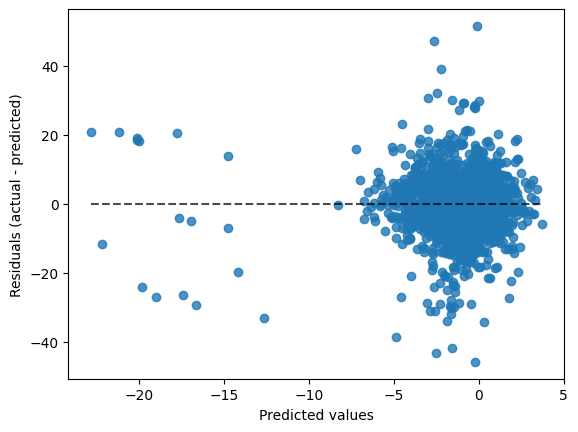

In [418]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

alt_prediction = PredictionErrorDisplay(
    y_true=y_test, y_pred=alt_regressor.predict(x_test))
alt_prediction.plot()

plt.show()

## Test Code


#### Single article from internet


In [419]:
# multi_output_regressor
article = '''Elon Musk meets with Netanyahu in Israel, tours kibbutz attacked by Hamas
The SpaceX founder also reached a ‘principle understanding’ with Israel to operate Starlink satellites in Gaza
By Jennifer Hassan and Aaron Gregg
Updated November 27, 2023 at 12:03 p.m. EST|Published November 27, 2023 at 9:09 a.m. EST

Israeli Prime Minister Benjamin Netanyahu, center, takes Elon Musk, left, on a tour of the Kfar Aza kibbutz on Monday. (Amos Ben-Gershom/GPO/Getty Images)
Listen
5 min

Share

Comment
1671
Add to your saved stories
Save
Elon Musk met with Israeli Prime Minister Benjamin Netanyahu on Monday in Israel, where the pair toured the Kfar Aza kibbutz, one of the Jewish communities attacked by Hamas militants during their Oct. 7 cross-border assault.

Get a curated selection of 10 of our best stories in your inbox every weekend.
After touring the scene of the violence, Musk was shown a video documenting some of the atrocities that took place, according to a conversation between the two men broadcast afterward on X, formerly known as Twitter. Musk said it was jarring to visit the site and troubling to see the joy on the faces of Hamas militants as they killed innocent people.

“It’s one thing obviously if civilians die accidentally, but it’s another thing to revel in the joy of killing civilians. … That’s evil,” Musk said.

Musk also rebuffed arguments that Israel has disproportionately killed civilians in Gaza, saying the actions of Hamas militants were intentional. “There is an important difference here, which is Israel tries to avoid killing civilians,” Musk said.

The trip comes as Musk faces widespread criticism for his decision to loosen content moderation on X after he purchased the platform last year. Since the Hamas attack, antisemitic content has surged more than 900 percent on the platform, The Washington Post reported. Disinformation specialists have accused Musk of playing a uniquely potent role by easing moderation standards and amplifying antisemitic tropes.

Musk has also been condemned by the White House for indicating support for an antisemitic conspiracy theory on X, a move U.S. officials called an “abhorrent promotion of antisemitic and racist hate.” A number of major advertisers have fled the platform after their ads appeared next to pro-Nazi posts.

Musk did not directly address those allegations in his conversation with Netanyahu on Monday, but he said there is a need to “stop the propaganda that is convincing people to engage in murder.” The militants must be “neutralized,” he added.

Later on Monday, Musk met with Israeli President Isaac Herzog, who decried “the oldest disease in humanity, antisemitism” and pointed to Musk’s “huge role” in preventing antisemitic content from spreading online, according to Herzog’s press office.

“We need to fight it together, because on the platforms which you lead, unfortunately, there’s a harboring of a lot of all the hate,” Herzog told Musk.

Referring to his meeting with Netanyahu, Musk called for three things to happen in Gaza: the killing of those who “insist on murdering civilians”; the overhaul of education, so a new generation of killers doesn’t take hold; and the development of prosperity.

Watching Hamas militants kill innocents illustrated how propaganda can incite people to violence, Musk said.

“These people have been fed propaganda since they were children. And it’s remarkable what humans are capable of if they’re fed falsehoods from when they are children,” Musk said. “They will think that the murder of innocent people is a good thing. That is how much propaganda can affect people’s minds.”

Starlink deal
Separately on Monday, Musk reached a “principle understanding” with Israel to operate SpaceX’s Starlink satellites in Gaza, according to Israeli Communications Minister Shlomo Karhi, but only with Israeli approval.

Israeli officials have warned him against supplying aid organizations within Gaza with internet connectivity through Starlink, saying it would be used by Hamas.

Gaza has suffered several communications blackouts since the war began, effectively sealing off the enclave’s residents from the outside world and one another. Aid groups inside the strip said Palestinians were unable to contact emergency services amid heavy strikes under those blackouts.

“This understanding is vital, as is it for everyone who desires a better world, free of evil and free of anti-Semitism, for our children’s sake,” Karhi wrote on X before welcoming Musk to the country.

SpaceX did not immediately respond to a request for comment.

How Starlink would operate in Gaza was not immediately clear. Starlink uses a constellation of about 5,000 satellites operated by SpaceX to beam internet signals to stations on the ground. It’s used primarily in rural and remote areas without broadband access to the internet and has served as a communications lifeline in disaster zones.

But it has also sparked controversy, especially in the war in Ukraine, where government officials have called it critical to that country’s war effort against Russian invaders.

Musk has said that he did not want it to be used for offensive purposes on the grounds that it could escalate the conflict, and when Ukraine asked that it be turned on for an attack on Russian forces in Crimea, he refused. At the time, the Pentagon did not have a contract with SpaceX for the use of the Starlink system. Since then, however, it has agreed to a contract for Starlink’s use in Ukraine, though it has declined to discuss the nature of the contract or how it governs the use of the system.

Starlink receivers also reportedly have been sent to Iran for use by dissidents there, though the details are unknown.'''
def convert(article): return re.sub(r'&#\d+;', '',  article.lower())

results = pd.DataFrame(apply_modeling_model(apply_text_models([convert(article)], tfidf_vectorizer, svd_fitter), alt_regressor), columns=hold.index)
results.loc[:, results.ge(0).any()]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LinearRegression was fitted without f

ticker,AAPL,BBWI,TECH,BWA,BMY,BG,CCL,CF,CMG,CMCSA,...,PSA,REGN,RHI,RCL,TSCO,VLO,VRTX,VTRS,WFC,WDC
0,0.00873,0.036129,0.013577,0.018931,0.059452,0.014209,0.00165,0.058073,0.163617,0.005548,...,0.024971,0.211905,0.007349,0.044691,0.017942,0.020907,0.011698,0.012568,0.009198,0.003185
